<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AlexNet**

AlexNet es una estructura de Red Neuronal Convolucional con una arquietectura de 5 capas convolucionales y 3 capas densas. No obstante, lo nuevo de este tipo de estructurad de red es el uso de:

1. Función de activación ReLU: calculo más sencillo, lo cual mejora hasta 6 veces el tiempo si se usase una tanh
2. Overlapping Pooling: forma de regularización de la red
3. Entrenamiento en GPU: incremento en la velocidad de computo para *Big data* 

Articulo: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

Nota: las imagenes de entrada deben poseer dimensiones de 227x227

In [1]:
# Librerias principales
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
import matplotlib.image as mpimg
import cv2

# Reducción de dimensiones 
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


# Load Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

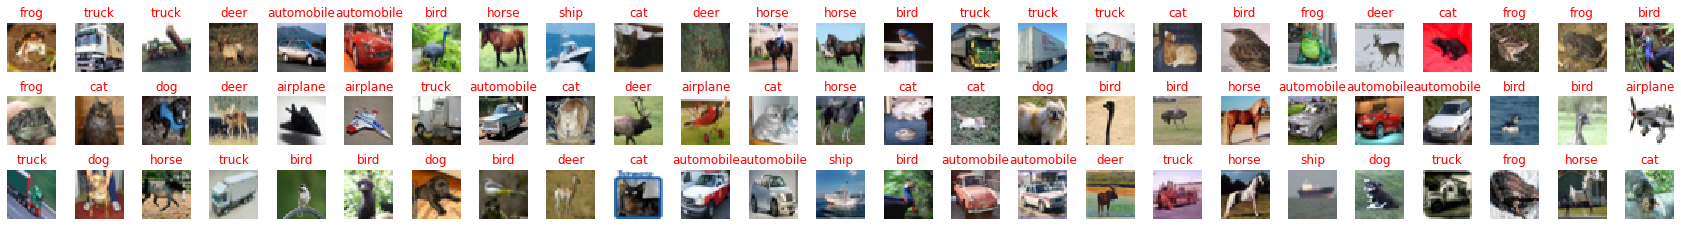

In [3]:
n_rows = 3
n_cols = 25
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows): 
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(train_images[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[train_labels[index][0]], c='r')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show() 

La complejidad de las imagenes cambia sustancialmente en comparación con la usadas en LeNet-5

In [4]:
dsize = (256,256)

# Entrenamiento 
num_train = 2850
X_train, y_train = np.zeros((num_train,256,256,3)), train_labels[0:num_train]
for i in range(num_train):
  img_resize = cv2.resize(train_images[i], dsize, interpolation = cv2.INTER_AREA)
  X_train[i] = img_resize 

# Validación 
num_valid = 850
X_valid, y_valid = np.zeros((num_valid,256,256,3)), train_labels[num_train:num_train+num_valid]
k=0
for i in range(num_train,num_train+num_valid):
  img_resize = cv2.resize(train_images[i], dsize, interpolation=cv2.INTER_AREA)
  X_valid[k] = img_resize 
  k += 1

# Test 
num_test = 100
X_test, y_test = np.zeros((num_test,256,256,3)), test_labels[0:num_test]
for i in range(num_test):
  img_resize = cv2.resize(test_images[i], dsize, interpolation = cv2.INTER_AREA)
  X_test[i] = img_resize 

print('Training samples: ', X_train.shape)
print('Validation samples: ', X_valid.shape)
print('Testing samples: ', X_test.shape)

del train_images, train_labels, test_images, test_labels


Training samples:  (2850, 256, 256, 3)
Validation samples:  (800, 256, 256, 3)
Testing samples:  (100, 256, 256, 3)


# Modelo de Deep Learning

Filtros de imagen aprendidos por la primera capa de AlexNet.
http://d2l.ai/_images/filters.png

In [5]:
model = keras.models.Sequential([
                                 
                                 # Estructura de extracción de características

                                 # Las ventas de convolución son grandes para de esta manera capturar más imagenes 
                                 keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                 keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                 keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                                 
                                 # Estructura densa de la Red
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(4096, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(4096, activation='relu'),
                                 keras.layers.Dropout(0.5),

                                 # Capa de salida 
                                 keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 384)       8

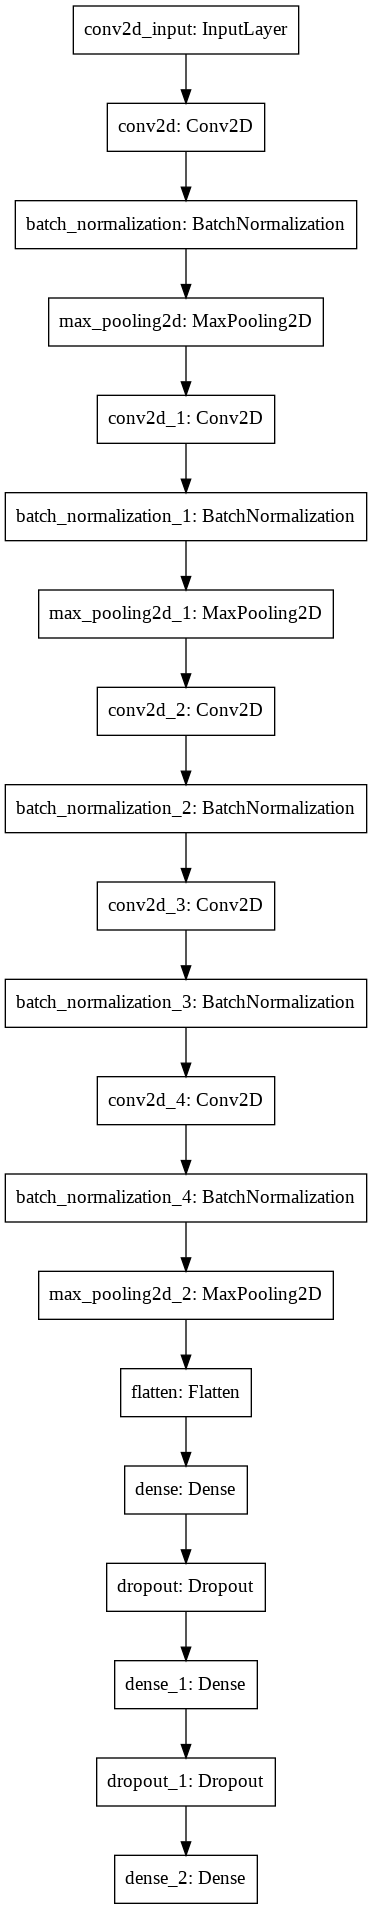

In [6]:
tf.keras.utils.plot_model(model)

In [7]:
model.compile(loss='sparse_categorical_crossentropy', # Función de costo a derivar
              optimizer=tf.optimizers.SGD(lr=0.001),  # Optimización: gradiente descendente     
              metrics=['accuracy']                    # Monitoriar la medida de desempeño (no lo deriva-> solo para ver la tarea final)   
              )

history = model.fit(X_train,                           # Conjunto de entrenamiento
                   y_train,                           # Etiquetas 
                   epochs=100,                        # Epocas: número de veces que se ejecutaran el algoritmo de backpropagation 
                   validation_data=(X_valid, y_valid) # Conjunto de validación (evaluar el desempeño)
                   ) 

Epoch 1/100
90/90 [==============================] - 6s 62ms/step - loss: 3.5239 - accuracy: 0.1681 - val_loss: 2.7680 - val_accuracy: 0.0763
Epoch 2/100
90/90 [==============================] - 5s 51ms/step - loss: 2.8213 - accuracy: 0.2295 - val_loss: 2.0844 - val_accuracy: 0.2750
Epoch 3/100
90/90 [==============================] - 5s 51ms/step - loss: 2.4249 - accuracy: 0.2786 - val_loss: 2.1650 - val_accuracy: 0.2825
Epoch 4/100
90/90 [==============================] - 5s 51ms/step - loss: 2.2059 - accuracy: 0.3168 - val_loss: 1.7204 - val_accuracy: 0.3975
Epoch 5/100
90/90 [==============================] - 5s 52ms/step - loss: 2.0153 - accuracy: 0.3505 - val_loss: 2.0458 - val_accuracy: 0.3000
Epoch 6/100
90/90 [==============================] - 5s 52ms/step - loss: 1.8910 - accuracy: 0.3604 - val_loss: 1.8509 - val_accuracy: 0.3663
Epoch 7/100
90/90 [==============================] - 5s 52ms/step - loss: 1.7876 - accuracy: 0.4028 - val_loss: 1.6864 - val_accuracy: 0.4050
Epoch 

# Resultados

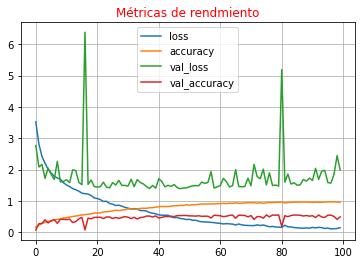

In [8]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

In [9]:
pred_ = np.round(model.predict(X_test))
pred_NN = np.array([x.argmax() for x in pred_])

In [10]:
print("Accuracy :", accuracy_score(y_test, pred_NN))
print(confusion_matrix(list(y_test), list(pred_NN)))
print(classification_report(y_test, pred_NN, target_names=class_names))

Accuracy : 0.48
[[ 7  0  0  0  0  0  0  0  3  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 3  1  3  0  0  0  1  0  0  0]
 [ 1  1  1  2  0  4  0  0  1  0]
 [ 2  0  0  0  2  1  0  0  2  0]
 [ 2  0  1  0  2  2  0  0  1  0]
 [ 4  0  3  1  4  0  4  0  0  0]
 [ 4  0  1  0  1  0  0  3  2  0]
 [ 1  1  0  0  0  0  0  0 11  0]
 [ 0  2  0  0  0  0  0  0  1  8]]
              precision    recall  f1-score   support

    airplane       0.29      0.70      0.41        10
  automobile       0.55      1.00      0.71         6
        bird       0.33      0.38      0.35         8
         cat       0.67      0.20      0.31        10
        deer       0.22      0.29      0.25         7
         dog       0.29      0.25      0.27         8
        frog       0.80      0.25      0.38        16
       horse       1.00      0.27      0.43        11
        ship       0.52      0.85      0.65        13
       truck       1.00      0.73      0.84        11

    accuracy                           0.48       100
   

"Esta red demostró, por primera vez, que las características obtenidas mediante el aprendizaje pueden trascender las características diseñadas manualmente, rompiendo el paradigma anterior en visión por computadora."